### Training loop stuff


In [ ]:
# | hide
import nbdev
from nbdev.showdoc import *


nbdev.nbdev_export()


In [ ]:
# | default_exp training


In [ ]:
# | export
from tidygrad.tensor import Tensor
from tidygrad.utils import noop
import numpy as np


In [ ]:
# | export
def add_callbacks(func):
    print("Adding callbacks", func.__name__)

    def decorator(self):
        full_name = func.__name__.replace("do_", "")
        pre_name = f"pre_{full_name}"
        post_name = f"post_{full_name}"
        for callback in self.callbacks:
            getattr(callback, pre_name, noop)(self)

        func(self)
        for callback in self.callbacks:
            getattr(callback, post_name, noop)(self)

    return decorator


In [ ]:
# | export
### Fastai style

class Dataset:
    def __getitem__(self, idx):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def shuffle(self):
        raise NotImplementedError

    def collate_fn(self, batch):
        raise NotImplementedError


class DataLoader:
    def __init__(self, dataset, batch_size=64, shuffle=True, batch_tfms=()):
        self.batch_tfms = batch_tfms
        self.dataset = dataset  # indexed dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return len(self.dataset) // self.batch_size

    def __iter__(self):
        if self.shuffle:
            self.dataset.shuffle()
        self.i = 0
        return self

    def __next__(self):
        if self.i + self.batch_size > len(self.dataset):
            raise StopIteration

        batch = [self.dataset[self.i + i] for i in range(self.batch_size)]
        self.i += self.batch_size
        collated = self.dataset.collate_fn(batch)
        for tfm in self.batch_tfms:
            collated = tfm(*collated)
        return [Tensor(t) for t in collated]


class DataLoaders:
    def __init__(self, train: DataLoader, test: DataLoader):
        self.train = train
        self.test = test


In [ ]:
# | export

class DictLoggerCallback:
    val_loss = 0
    val_error = 0

    def __init__(self, metrics=None):
        self.metrics = [] if metrics is None else metrics

    def log(self, metric, value, accum=False, step: int = None):
        if step is None:
            step = self.metrics[-1]["step"] + 1 if self.metrics else 0

        if not self.metrics or step != self.metrics[-1]["step"]:
            self.metrics.append({"step": step})

        if metric in self.metrics[-1] and accum:
            self.metrics[-1][metric] += value
        else:
            self.metrics[-1][metric] = value

    def post_calc_loss(self, learner):
        if learner.training:
            self.log("loss", float(learner.loss.data), step=learner.step)
            self.log("error", 1 - float((learner.preds.data.argmax(1) == learner.batch[1].data).mean()), step=learner.step)
        else:
            self.val_loss += float(learner.loss.data)
            self.val_error += 1 - float((learner.preds.data.argmax(1) == learner.batch[1].data).mean())
            # self.log("val_loss", float(learner.loss.data), accum=True, step=learner.step)

    # def pre_epoch(self, learner):
    #

    def post_epoch(self, learner):
        # val_loss = self.metrics[-1]["val_loss"] / len(learner.dl)
        self.log("val_loss", self.val_loss / len(learner.dl), step=learner.step)
        self.log("val_error", self.val_error / len(learner.dl), step=learner.step)
        # self.log("epoch", learner.epoch, step=learner.step)
        self.val_loss = 0
        self.val_error = 0


In [ ]:
# | export

class Learner:
    # dataloaders - train, test
    # model - function that outputs a tensor that can be fed into a loss function
    # loss_func - function that takes in a tensor and outputs a scalar
    # optimizer - Optimizer object
    def __init__(self, dataloaders, model, loss_func, optimizer, callbacks=[]):
        self.dataloaders = dataloaders
        self.model = model
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.callbacks = callbacks if callbacks else []

        # The state of the learner. These are updated during training by various do_ functions
        self.training = False  # True if training, False if val/test.
        self.epoch = 0  # current epoch, starts with 1 when you start trainig.
        self.step = 0  # current step, increases by 1 every (training) batch
        self.dl = None  # current dataloader, could be train or test or val
        self.batch = None  # The current batch as a tuple of (x, y)
        self.preds: Tensor = None  # Output of the model

    def fit(self, epochs, start_epoch=0, start_step=None):
        self.start_epoch = start_epoch
        self.n_epochs = epochs
        self.step = self.step if start_step is None else start_step
        self.do_fit()

    @add_callbacks
    def do_fit(self):
        for e in range(self.start_epoch + 1, self.start_epoch + 1 + self.n_epochs):
            self.epoch = e
            self.do_epoch()

    @add_callbacks
    def do_epoch(self):
        self.training = True
        self.dl = self.dataloaders.train
        self.do_all_batches()
        self.dl = self.dataloaders.test
        self.training = False
        self.do_all_batches()

    @add_callbacks
    def do_all_batches(self):
        for batch in self.dl:
            if self.training: self.step += 1
            self.batch = batch
            self.do_batch_forward()
            self.do_calc_loss()
            if self.training: self.do_batch_backward()

    @add_callbacks
    def do_calc_loss(self):
        _, y = self.batch
        self.loss = self.loss_func(self.preds, y)

    @add_callbacks
    def do_batch_forward(self):
        x, _ = self.batch
        self.preds = self.model(x)

    @add_callbacks
    def do_batch_backward(self):
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()


Adding callbacks do_fit
Adding callbacks do_epoch
Adding callbacks do_all_batches
Adding callbacks do_calc_loss
Adding callbacks do_batch_forward
Adding callbacks do_batch_backward


In [ ]:
# | export
import numpy as np


def one_hot_encode_batch(y_batch, n_classes):
    batch_size = len(y_batch)
    assert batch_size > 0
    assert n_classes > 0
    assert y_batch.shape == (batch_size, )
    assert np.min(y_batch) >= 0

    # Initialize a zero matrix of shape (batch_size, num_classes)
    one_hot_matrix = np.zeros((batch_size, n_classes))

    # Fill in the appropriate elements
    one_hot_matrix[np.arange(batch_size), y_batch] = 1

    return one_hot_matrix


In [ ]:
def mnist_batch_tfm(x, y):
    return (x.reshape(x.shape[0], -1) / 255 - 0.5, y)


In [ ]:
from tidygrad.utils.datasets import download_file
import os
from pathlib import Path


In [ ]:
class MNIST(Dataset):
    """MNIST Dataset"""
    def __init__(
        self,
        path="datasets",
        url=None,
        train=True,
        item_tfms=(),
    ):
        self.item_tfms = item_tfms
        self.path = Path(path)
        self.train = train
        self.url = (url if url is not None else "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz")
        self.load_data()

    def load_data(self):
        file_path = self.path / "mnist.npz"
        download_file(
            "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz",
            file_path,
        )
        with np.load(file_path) as f:
            self.x = f["x_train"] if self.train else f["x_test"]
            self.y = f["y_train"] if self.train else f["y_test"]

            self.x = self.x.astype(np.float32)
            self.y = self.y.astype(np.int32)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise TypeError("Index must be an integer.")

        x, y = self.x[idx], self.y[idx]
        for tfm in self.item_tfms:
            x, y = tfm(x, y)
        return x, y

    def __len__(self):
        return len(self.x)

    def shuffle(self):
        idx = np.random.permutation(len(self))
        self.x, self.y = self.x[idx], self.y[idx]

    def collate_fn(self, batch: list):
        return np.stack([item[0] for item in batch]), np.stack([item[1] for item in batch])


In [ ]:
mnist = MNIST()


In [ ]:
from lovely_numpy import Lo
import matplotlib.pyplot as plt


In [ ]:
Lo(mnist.x), Lo(mnist.y)


(array[60000, 28, 28] f32 n=47040000 (0.2Gb) x∈[0., 255.000] μ=33.318 σ=78.567,
 array[60000] i32 0.2Mb x∈[0, 9] μ=4.454 σ=2.889)

In [ ]:
Lo(mnist[0][0])


array[28, 28] f32 n=784 (3.1Kb) x∈[0., 255.000] μ=35.108 σ=79.649

In [ ]:
# plt.imshow(mnist.x[0])


In [ ]:
mnist_dl = DataLoader(mnist, batch_size=64, batch_tfms=[mnist_batch_tfm])
x, y = next(iter(mnist_dl))


In [ ]:
mnist_dl


<__main__.DataLoader>

In [ ]:
from tidygrad.functional import sigmoid, BCE_loss
from tidygrad.optim import Adam
from functools import partial


In [ ]:
INT_DIM = 128

w1 = Tensor(np.random.randn(784, INT_DIM) * 1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")

w2 = Tensor(np.random.randn(INT_DIM, 10) * 1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")


def linear_model(inputs, params, debug=list()):
    inputs.data = inputs.data.reshape(inputs.data.shape[0], -1)
    x = inputs
    w1, b1, w2 = params
    z1 = sigmoid(x.mmul(w1, "z1") + b1)
    z2 = z1.mmul(w2, "z2")

    return z2


MM_func = partial(linear_model, params=[w1, b1, w2])

optimizer = Adam([w1, b1, w2], lr=0.001)
loss_f = lambda preds, targets: BCE_loss(preds, one_hot_encode_batch(targets.data, 10))
metrics = []

student = Learner(
    dataloaders=DataLoaders(mnist_dl, mnist_dl),
    model=MM_func,
    loss_func=loss_f,
    optimizer=optimizer,
    callbacks=[DictLoggerCallback(metrics=metrics)],
)


In [ ]:
student.fit(epochs=5)
# metrics


In [ ]:
from matplotlib import pyplot as plt


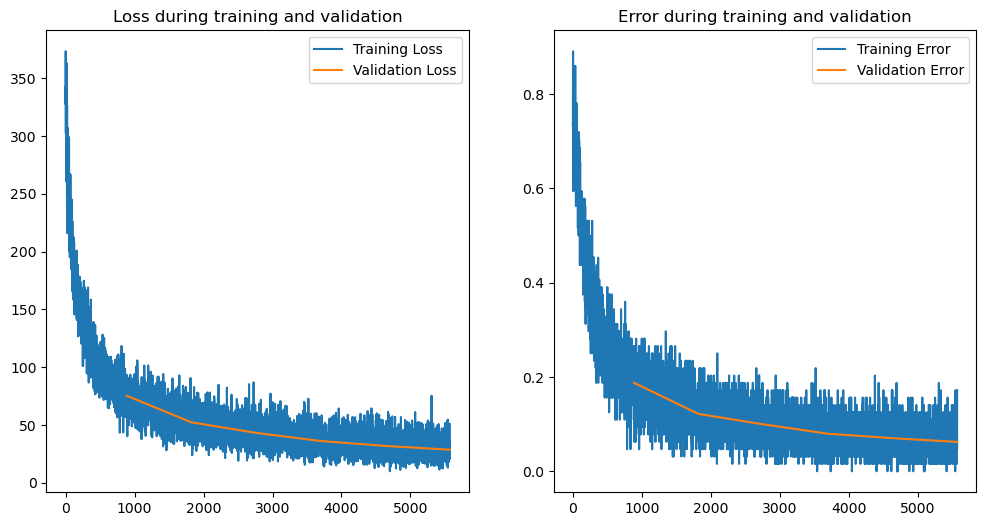

In [ ]:
# [{'step': 0, 'epoch': 1, 'loss': 1749.5567287118765, 'error': 0.859375},
#  {'step': 1, 'loss': 1601.6047416180406, 'error': 0.875},
#  {'step': 2, 'loss': 1745.9560457111977, 'error': 0.890625},
#  {'step': 3, 'loss': 1699.4515380436496, 'error': 0.875},
#  {'step': 4, 'loss': 1577.375057199632, 'error': 0.859375},
#  {'step': 5, 'loss': 1365.698424993677, 'error': 0.859375},
#  {'step': 6, 'loss': 1344.940893761817, 'error': 0.90625},
#  {'step': 7, 'loss': 1232.984272741041, 'error': 0.9375},
#  {'step': 8, 'loss': 1201.955485184156, 'error': 0.90625},
#  {'step': 9, 'loss': 952.4247807282655, 'error': 0.90625},
#  {'step': 10, 'loss': 1006.2738835333373, 'error': 0.875},
#  {'step': 11, 'loss': 813.0388986738951, 'error': 0.890625},
#  ...
# {'step': 931, 'loss': 58.18602855000384, 'error': 0.15625},
#  {'step': 932, 'loss': 76.38823440023558, 'error': 0.203125},
#  {'step': 933, 'loss': 67.58771792428136, 'error': 0.15625},
#  {'step': 934, 'loss': 69.71772686297123, 'error': 0.21875},
#  {'step': 935, 'loss': 92.22990453131322, 'error': 0.25},
#  {'step': 936, 'loss': 73.7377055829916, 'error': 0.15625},
#  {'step': 937, 'val_loss': 75.72548226285275, 'val_error': 0.1858991462113127}]

losses = []
errors = []
val_losses = []
val_errors = []

for idx, data in enumerate(metrics[50:]):
    if 'loss' in data: losses.append((idx, data['loss']))
    if 'error' in data: errors.append((idx, data['error']))
    if 'val_loss' in data: val_losses.append((idx, data['val_loss']))
    if 'val_error' in data: val_errors.append((idx, data['val_error']))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(*zip(*losses), label='Training Loss')
plt.plot(*zip(*val_losses), label='Validation Loss')
plt.title('Loss during training and validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(*zip(*errors), label='Training Error')
plt.plot(*zip(*val_errors), label='Validation Error')
plt.title('Error during training and validation')
plt.legend()

plt.show()
